In [108]:
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.integrate import odeint

import numdifftools as nd

In [182]:

class Species:
    # initialize species, make it aware of parent reaction system
    def __init__(self, system, name):
        self.system = system
        self.name = name
        
        self.equation = "0"
        self.components = ["0"]
        self.dt = None
        
        self.generateFunction()
        
    def generateFunction(self):
        self.equation = 'lambda X, P: ' + " + ".join(self.components)
        self.dt = eval(self.equation)
        
class Run: 
    def __init__(self,t,solution, model):
        self.time = t
        self.solution = solution
        self.model = model
        
    def plot(self):
        
        for i, species in enumerate(self.model.species):
            plt.plot(self.time,self.solution[:,i],label=species.name)
        plt.legend()
        plt.show()
        
    def analyzeStability(self):
        jacobianF = nd.Jacobian(model.dX)
        jacobian = jacobianF(self.solution[-1,:],self.time[-1],np.array(self.model.parameters))
        print("===== STABILITY ANALYSIS =====\nThe stability analysis is only valid for steady states. \n")
        print("Jacobian at time={} ".format(self.time[-1]) )
        print(jacobian)
        eig_values, eig_vectors = np.linalg.eig(jacobian)
        print("\n")
        print("Eigen values")
        print(eig_values)
        print("\n")
        print("Eigen vectors")
        print(eig_vectors)
        print("\n")
        
        negReal = np.where(eig_values < 0)
        zero = np.where(eig_values == 0)
        if np.sum(negReal) == len(eig_values):
            print("All eigenvalues are negative & real, \nthe steady state is asymptotically stable")
        elif np.sum(negReal) > 0:
            print("There are eigen values equal zero. \nTry to redo the analysis without conctant species")
        else:
            print("Not all eigenvalues are negative & real, \nthe steady state is unstable")
        
class Model:
    def __init__(self):
        self.species = []
        self.parameters = []
        self.loaded = False
        
    def getSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return s
        print("error: species " + name + " was not found")
        return None
    
    def indexSpecies(self, name):
        for i, s in enumerate(self.species):
            if s.name == name:
                return i
        print("error: species " + name + " was not found")
        return None
        
    def addSpecies(self, name):
        self.species.append(Species(self, name))
        
    def addReaction(self, reactants, stoichometry, k, kinetic_dependencies):

        self.parameters.append(k[0])
        parameter = "P[{}]".format(len(self.parameters)-1)

        
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        order = len(kinetic_dependencies)
        
        nth = " * " if order > 0 else ""
        v = parameter + nth +  "*".join(species)
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
            
    def addMichaelisReaction(self, reactants, stoichometry, k, kinetic_dependencies):
        self.parameters.append(k[0]) #k_cat
        self.parameters.append(k[1]) #K_m
        
        k_cat = "P[{}]".format(len(self.parameters)-2)
        K_m = "P[{}]".format(len(self.parameters)-1)
        
        species = ["X[{}]".format(self.indexSpecies(name)) for name in kinetic_dependencies]
        limiting_substrate = "X[{}]".format(self.indexSpecies(reactants[0]))
        
        v = k_cat + " * " + species[0] + " * " + limiting_substrate + " /(" + K_m + " + " +  limiting_substrate + ")"
        
        for i, name in enumerate(reactants):
            species = self.getSpecies(name)
            species.components.append("({})*".format(stoichometry[i]) + v)
            species.generateFunction()
        
    def dX(self, X,t, P):
        dX = np.array([species.dt(X,P) for species in self.species])
        return dX
    
    def load(self, path):
        if self.loaded:
            print("warning: model will be overwritten")
            self.species = []
            self.parameters = []
                  
        with open (path, "r") as myfile:
            data=myfile.readlines()
    

        # read model from system definition
        for i, line in enumerate(data):
            #remove newline and spaces
            line = line.strip("\n")
            line = line.replace(" ","")


            # match first line for species definition
            if i == 0:
                species_match = re.findall('[A-Z]+', line)
                if species_match:
                    for species in species_match:
                        self.addSpecies(species)
                else:
                    print("error: no species found in first line of system definition")

            #match consecutive lines for reaction equations
            else:
                if len(line) > 0 and line[0] != "#":
                    reaction_match = re.split("-.*->", line)
                    reaction_definition = re.findall("-([A-Z])-(.*)->", line)[0]

                    #match reaction constants and dependencies
                    constants = re.findall("(\d*\.?\d+)", reaction_definition[1])

                    if(len(constants) > 0):
                        constants = [float(i) for i in constants]
                        kinetic_dependencies = re.findall('[0-9]*[A-Z]+', reaction_definition[1])
                        reaction_order = len(kinetic_dependencies)

                    else: 
                         print("error: reaction constant was missing")

                    #match products and educts
                    if len(reaction_match) > 0:
                        educts =  reaction_match[0]
                        products = reaction_match[1]



                        educt_species = re.findall('[0-9]*[A-Z]+', educts)
                        product_species = re.findall('[0-9]*[A-Z]+', products)


                        reactants = []
                        stoichometry = []

                        for educt in educt_species:

                            s = re.findall('[0-9]+', educt)
                            N = 1 if len(s) == 0 else int(s[0])
                            name = re.findall('[A-Z]+', educt)[0]

                            if name in reactants:
                                stoichometry[reactants.index(name)] -= N
                            else:
                                reactants.append(name)
                                stoichometry.append(-N)

                        for product in product_species:

                            s = re.findall('[0-9]+', product)
                            N = 1 if len(s) == 0 else int(s[0])
                            name = re.findall('[A-Z]+', product)[0]

                            if name in reactants:
                                stoichometry[reactants.index(name)] += N
                            else:
                                reactants.append(name)
                                stoichometry.append(N)

                        #stoichometric reaction        
                        if reaction_definition[0] == "S":

                            self.addReaction(reactants,stoichometry,constants,educt_species)      

                        #reaction with michaelis menten kinetics
                        if reaction_definition[0] == "M":

                            if len(educts) > 1:
                                print("warning: michaleis menten kinetic with more than one substrate specified. species " + educts[0] +" will be choosen as rate limiting.")

                            self.addMichaelisReaction(reactants,stoichometry,constants,educt_species)      
                            print(constants,kinetic_dependencies)

                        print("parse stoichometric reactions")
        
        
    #move to simulation run class
    def simulate(self,X0,duration):
        t = np.linspace(0,duration,1000)
        solution = odeint(self.dX,X0,t,args=(model.parameters,))
        
        return(Run(t,solution,self))
    
        
        

[2.0, 0.04] ['E']
parse stoichometric reactions
parse stoichometric reactions
parse stoichometric reactions


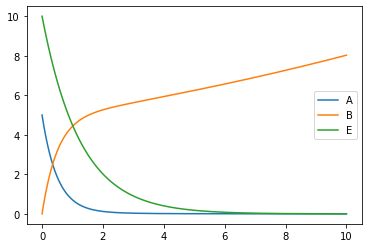

===== STABILITY ANALYSIS =====
The stability analysis is only valid for steady states. 

Jacobian at time=10.0 
[[-0.28245342  0.          0.        ]
 [ 0.28245342  0.05        0.        ]
 [ 0.          0.         -0.8       ]]


Eigen values
[ 0.05       -0.28245342 -0.8       ]


Eigen vectors
[[ 0.          0.7620886   0.        ]
 [ 1.         -0.64747275  0.        ]
 [ 0.          0.          1.        ]]


All eigenvalues are negative & real, 
the steady state is asymptotically stable


In [183]:
model = Model()
model.load("system.txt")

X0 = [5, 0, 10]
run = model.simulate(X0,10)
       
run.plot()
run.analyzeStability()

